# 設定の確認

In [21]:
# Get Spark version
spark_version = spark.version
print("Spark Version:", spark_version)

Spark Version: 3.4.3


In [22]:
# Get Scala version
sc = spark.sparkContext
scala_version = sc._jvm.scala.util.Properties.versionString()
print("Scala Version:", scala_version)

Scala Version: version 2.12.17


In [23]:
# Access Spark configuration
spark_conf = spark.sparkContext._conf

# Print out all configuration settings to find the repositories
for item in spark_conf.getAll():
    if "repositories" in item[0]:
        print(f"{item[0]}: {item[1]}")

spark.jars.repositories: https://mmlspark.azureedge.net/maven
Repositories: https://mmlspark.azureedge.net/maven


# LightGBM

参考

- https://microsoft.github.io/SynapseML/docs/Explore%20Algorithms/LightGBM/Quickstart%20-%20Classification,%20Ranking,%20and%20Regression/
  - データの読み込み意外はほぼこのページのとおり実行できる

In [9]:
import pyspark

packages = [
    "com.microsoft.azure:synapseml_2.12:1.0.4",
    "org.apache.hadoop:hadoop-azure:3.4.0",
    "org.apache.hadoop:hadoop-azure-datalake:3.4.0",
    "com.azure:azure-storage-blob:12.26.1"
]

spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
            .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
            .config("spark.jars.packages", ",".join(packages)) \
            .config("spark.executor.memory", "16g") \
            .config("spark.driver.memory", "16g") \
            .getOrCreate()

In [2]:
# これのインポートができなかったら何かうまくいってない
import synapse.ml
from synapse.ml.core.platform import *

In [4]:
df = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load(
        # この URL からの取得がうまくいかない
        # "wasbs://publicwasb@mmlspark.blob.core.windows.net/company_bankruptcy_prediction_data.csv"

        # かわりに Kaggle からダウンロードした CSV を使う
        # https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction
        "data.csv"
    )
)
# print dataset size
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

records read: 6819
Schema: 
root
 |-- Bankrupt?: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax ra

In [5]:
df.head(1)

24/07/01 07:46:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(Bankrupt?=1,  ROA(C) before interest and depreciation before interest=0.370594257300249,  ROA(A) before interest and % after tax=0.424389446140427,  ROA(B) before interest and depreciation after tax=0.40574977247176,  Operating Gross Margin=0.601457213277793,  Realized Sales Gross Margin=0.601457213277793,  Operating Profit Rate=0.998969203197885,  Pre-tax net Interest Rate=0.796887145860514,  After-tax net Interest Rate=0.808809360876843,  Non-industry income and expenditure/revenue=0.302646433889668,  Continuous interest rate (after tax)=0.780984850207341,  Operating Expense Rate=0.000125696868875964,  Research and development expense rate=0.0,  Cash flow rate=0.458143143520965,  Interest-bearing debt interest rate=0.000725072507250725,  Tax rate (A)=0.0,  Net Value Per Share (B)=0.147949938898487,  Net Value Per Share (A)=0.147949938898487,  Net Value Per Share (C)=0.147949938898487,  Persistent EPS in the Last Four Seasons=0.16914058806845,  Cash Flow Per Share=0.3116644266817

In [6]:
train, test = df.randomSplit([0.85, 0.15], seed=1)

In [7]:
from pyspark.ml.feature import VectorAssembler

feature_cols = df.columns[1:]
featurizer = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = featurizer.transform(train)["Bankrupt?", "features"]
test_data = featurizer.transform(test)["Bankrupt?", "features"]

In [8]:
train_data.groupBy("Bankrupt?").count().head()

Row(Bankrupt?=1, count=186)

In [10]:
from synapse.ml.lightgbm import LightGBMClassifier

model = LightGBMClassifier(
    objective="binary", featuresCol="features", labelCol="Bankrupt?", isUnbalance=True
)

In [11]:
model = model.fit(train_data)

[LightGBM] [Info] Saving data reference to binary buffer


[LightGBM] [Info] Loaded reference dataset: 93 features, 5791 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [12]:
from synapse.ml.lightgbm import LightGBMClassificationModel

if running_on_synapse():
    model.saveNativeModel("/models/lgbmclassifier.model")
    model = LightGBMClassificationModel.loadNativeModelFromFile(
        "/models/lgbmclassifier.model"
    )
if running_on_synapse_internal():
    model.saveNativeModel("Files/models/lgbmclassifier.model")
    model = LightGBMClassificationModel.loadNativeModelFromFile(
        "Files/models/lgbmclassifier.model"
    )
else:
    model.saveNativeModel("/tmp/lgbmclassifier.model")
    model = LightGBMClassificationModel.loadNativeModelFromFile(
        "/tmp/lgbmclassifier.model"
    )

f_index: Index([' Liability-Assets Flag', ' Net Income Flag',
       ' Current Liability to Equity', ' Current Liability to Liability',
       ' Equity to Liability', ' Net Value Per Share (C)',
       ' Gross Profit to Sales', ' Net worth/Assets',
       ' Current Liability to Current Assets',
       ' Working capitcal Turnover Rate', ' Realized Sales Gross Margin',
       ' After-tax net Interest Rate', ' Operating Funds to Liability',
       ' Current Ratio', ' Net Value Per Share (A)', ' CFO to Assets',
       ' Debt ratio %', ' Liability to Equity',
       ' Long-term Liability to Current Assets',
       ' Per Share Net profit before tax (Yuan ¥)', ' Total Asset Turnover',
       ' Working Capital to Total Assets', ' Quick Assets/Current Liability',
       ' Operating profit/Paid-in capital', ' Tax rate (A)',
       ' Net Income to Stockholder's Equity',
       ' Degree of Financial Leverage (DFL)', ' Total income/Total expense',
       ' Pre-tax net Interest Rate', ' Operating Pr

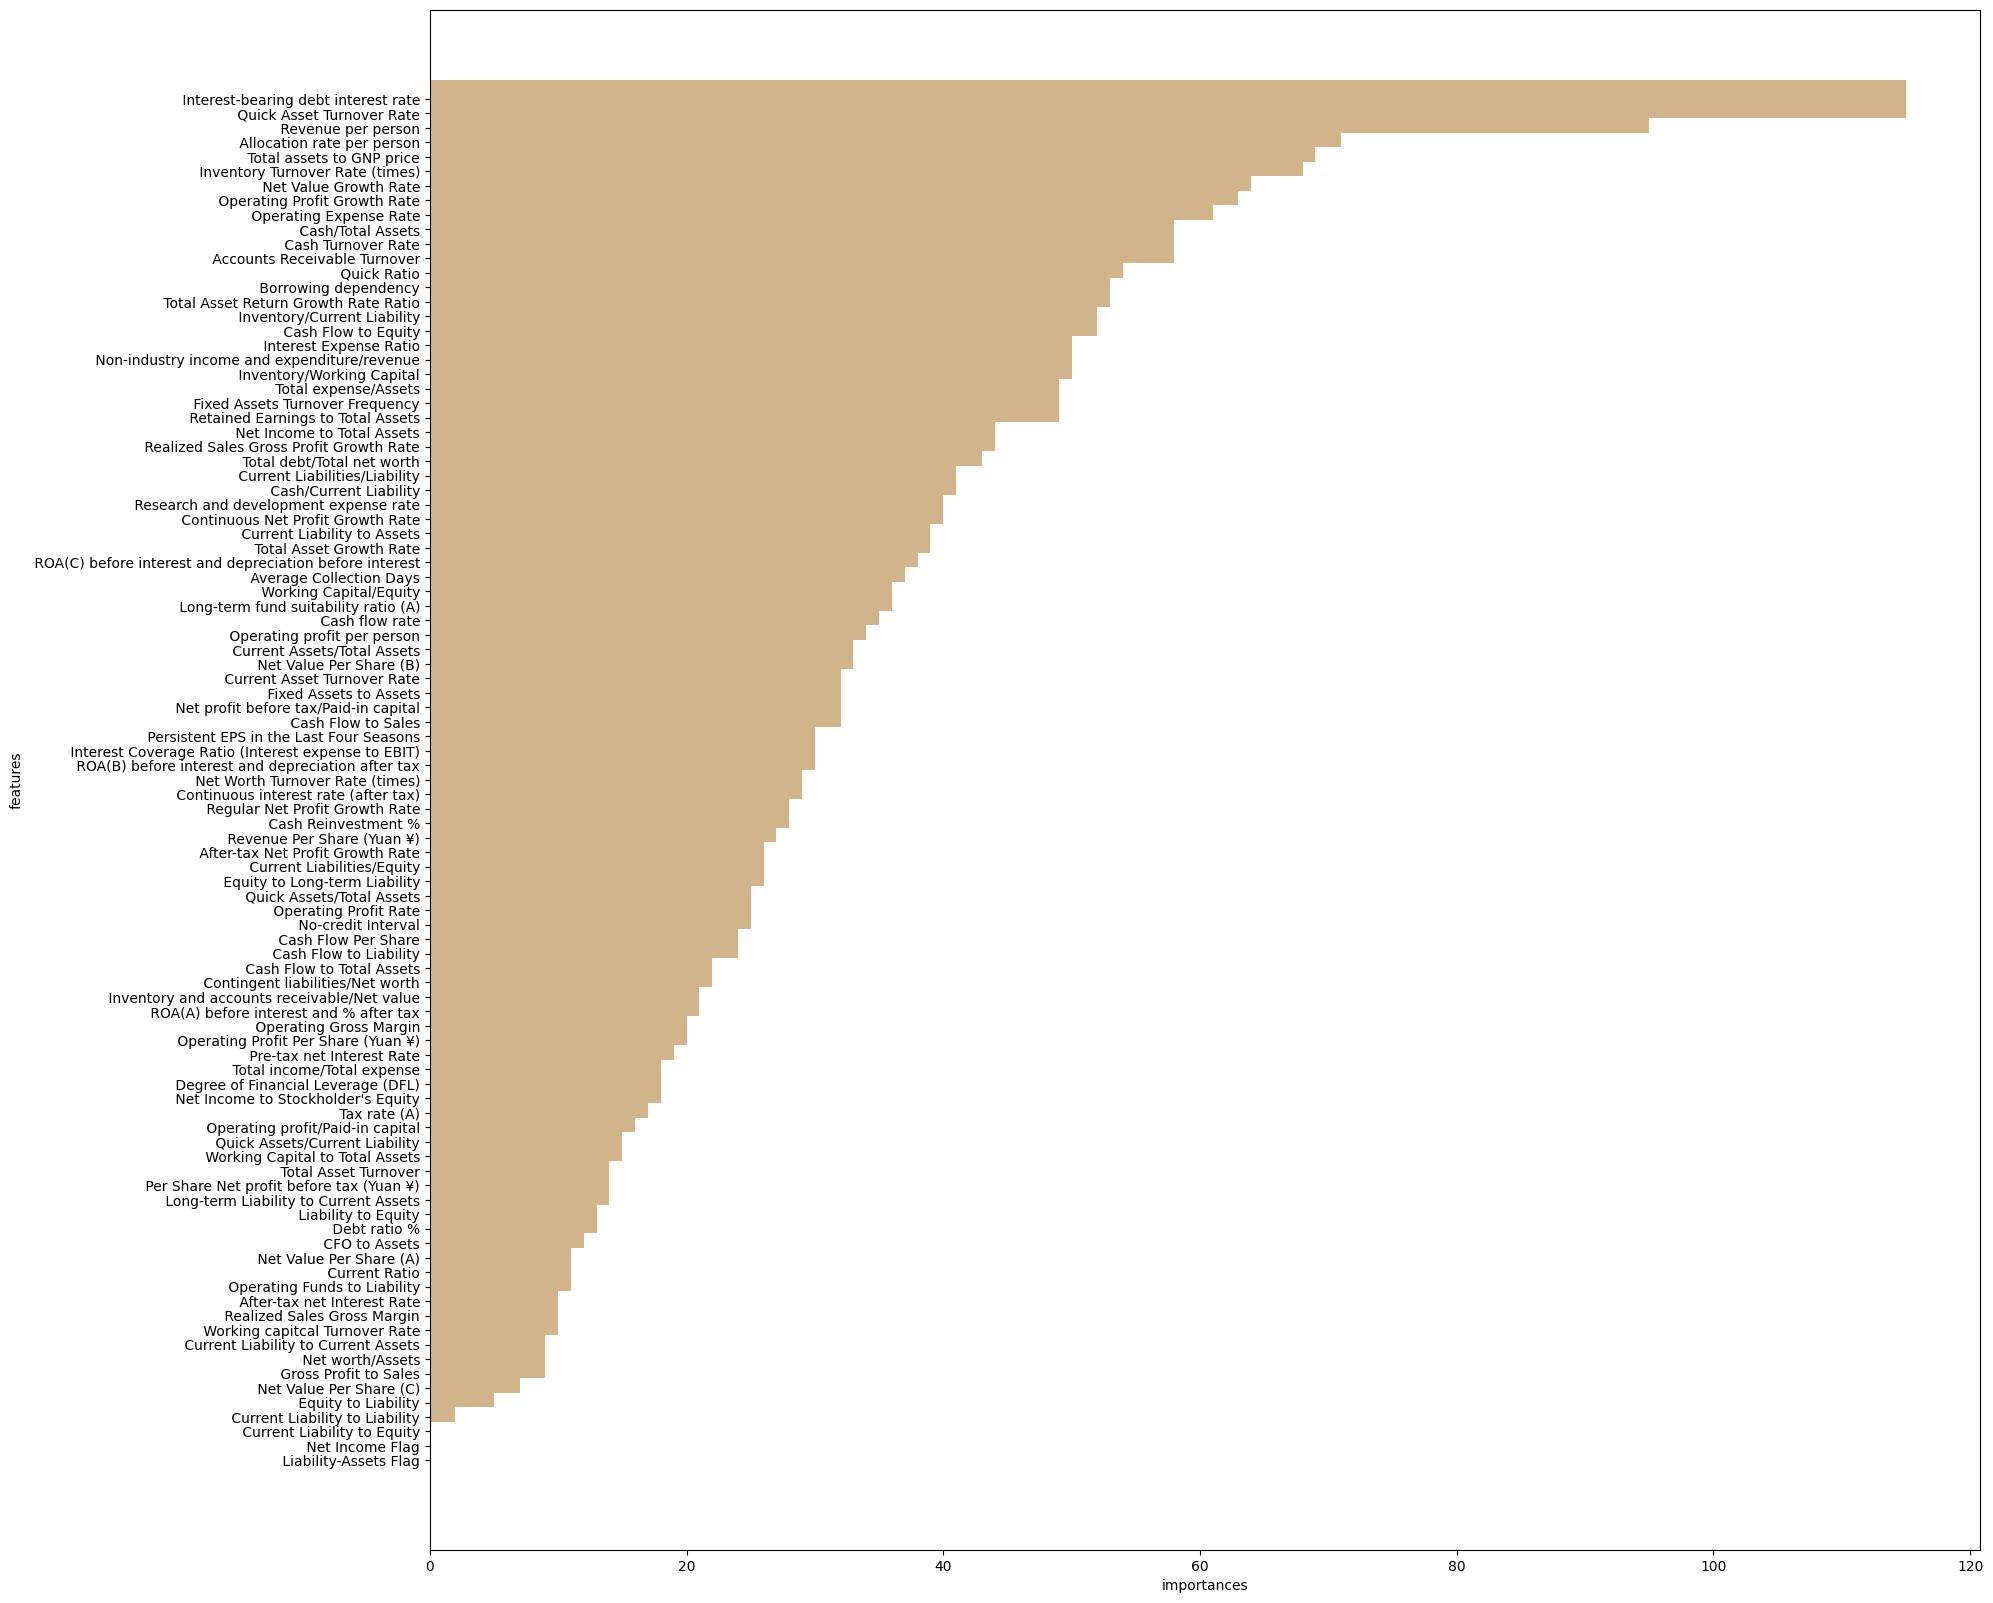

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model.getFeatureImportances()
fi = pd.Series(feature_importances, index=feature_cols)
fi = fi.sort_values(ascending=True)
f_index = fi.index
f_values = fi.values

# print feature importances
print("f_index:", f_index)
print("f_values:", f_values)

# plot
x_index = list(range(len(fi)))
x_index = [x / len(fi) for x in x_index]
plt.rcParams["figure.figsize"] = (20, 20)
plt.barh(
    x_index, f_values, height=0.028, align="center", color="tan", tick_label=f_index
)
plt.xlabel("importances")
plt.ylabel("features")
plt.show()

In [14]:
predictions = model.transform(test_data)
predictions.limit(10).toPandas()

,Bankrupt?,features,rawPrediction,probability,prediction
0,0,"[0.249305318578462, 0.259376362843437, 0.25938...","[4.796784154400139, -4.796784154400139]","[0.9918113523202132, 0.008188647679786753]",0.0
1,0,"[0.328620874567348, 0.286088094199738, 0.34348...","[-2.518786433308617, 2.518786433308617]","[0.07455163038602441, 0.9254483696139756]",1.0
2,0,"[0.334324574659972, 0.393044047099869, 0.38690...","[11.231374572151992, -11.231374572151992]","[0.9999867483412396, 1.3251658760464698e-05]",0.0
3,0,"[0.336274557597621, 0.373419101613607, 0.37614...","[4.124473517924595, -4.124473517924595]","[0.9840853649642729, 0.015914635035727084]",0.0
4,0,"[0.361721834933944, 0.394297863061492, 0.40409...","[2.6379222297723985, -2.6379222297723985]","[0.9332626701486868, 0.06673732985131325]",0.0
5,0,"[0.364841807634183, 0.31841474051461, 0.393115...","[-2.053209591777962, 2.053209591777962]","[0.11372847140640074, 0.8862715285935993]",1.0
6,0,"[0.365183054648272, 0.413977322285216, 0.39793...","[7.5222157528921, -7.5222157528921]","[0.9994593597860721, 0.0005406402139278572]",0.0
7,0,"[0.38487788231853, 0.422535979066725, 0.424808...","[8.582156651475508, -8.582156651475508]","[0.9998126147789235, 0.00018738522107650095]",0.0
8,0,"[0.393652805537952, 0.491550370693415, 0.43353...","[6.74859374007778, -6.74859374007778]","[0.9988288458700719, 0.001171154129928069]",0.0
9,0,"[0.398186515867986, 0.44608591365024, 0.439638...","[6.552090803485402, -6.552090803485402]","[0.9985749051623461, 0.0014250948376539048]",0.0


In [15]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification",
    labelCol="Bankrupt?",
    scoredLabelsCol="prediction",
).transform(predictions)
display(metrics)

DataFrame[evaluation_type: string, confusion_matrix: matrix, accuracy: double, precision: double, recall: double, AUC: double]

# SHAP

参考

- https://microsoft.github.io/SynapseML/docs/Explore%20Algorithms/Responsible%20AI/Tabular%20Explainers/
  - このページの example はできたけど、lightgbm は使ってない
  - lightgbm の model で回そうとしたら、explain_instances あたりからうまくいかなかった。lightgbm は features って名前のひとつのカラムに特徴量が全部入ってるけど、このページの example は特徴量の数だけカラムがあって、その違いのせいでできなかった
- https://github.com/microsoft/SynapseML/issues/1070#issuecomment-1139713881
  - この一番最後のコードを少しだけいじったら shap のプロットが出るようになった

In [16]:
from synapse.ml.lightgbm import LightGBMClassifier

model = LightGBMClassifier(
    objective="binary", featuresCol="features", labelCol="Bankrupt?", isUnbalance=True,
    featuresShapCol="shap_values"  # このオプションを追加した
)

In [17]:
model = model.fit(train_data)

[LightGBM] [Info] Saving data reference to binary buffer


[LightGBM] [Info] Loaded reference dataset: 93 features, 5791 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [18]:
# lightgbm のチュートリアルではここでモデルを一度保存して読み込みし直してるけど、
# これをすると shap value が消えてしまったのでコメントアウトしてる

# from synapse.ml.lightgbm import LightGBMClassificationModel

# if running_on_synapse():
#     model.saveNativeModel("/models/lgbmclassifier.model")
#     model = LightGBMClassificationModel.loadNativeModelFromFile(
#         "/models/lgbmclassifier.model"
#     )
# if running_on_synapse_internal():
#     model.saveNativeModel("Files/models/lgbmclassifier.model")
#     model = LightGBMClassificationModel.loadNativeModelFromFile(
#         "Files/models/lgbmclassifier.model"
#     )
# else:
#     model.saveNativeModel("/tmp/lgbmclassifier.model")
#     model = LightGBMClassificationModel.loadNativeModelFromFile(
#         "/tmp/lgbmclassifier.model"
#     )

In [19]:
predictions = model.transform(test_data)

In [20]:
test_data.head(1)

[Row(Bankrupt?=0, features=DenseVector([0.2493, 0.2594, 0.2594, 0.6501, 0.6501, 0.9976, 0.7959, 0.8078, 0.3036, 0.7799, 0.0022, 0.0016, 0.4243, 0.0, 0.0, 0.1577, 0.1577, 0.1577, 0.1877, 0.3036, 0.0036, 0.0728, 0.1426, 0.0224, 0.848, 0.6892, 0.6892, 0.2176, 0.0004, 0.0014, 0.2594, 0.3444, 0.0368, 0.0321, 0.6306, 0.0017, 0.0471, 0.9529, 0.0075, 0.3702, 0.0054, 0.0728, 0.1491, 0.3963, 0.0645, 0.0007, 0.0086, 2310000000.0, 0.0003, 0.0173, 0.0018, 0.384, 0.001, 0.9408, 0.7767, 0.8284, 0.0924, 0.0332, 0.0114, 0.0427, 0.2494, 0.277, 0.0097, 0.8156, 0.7413, 0.3275, 0.0008, 0.8682, 0.0021, 0.0973, 0.0009, 0.0008, 0.5944, 0.0003, 0.6717, 0.0877, 0.8156, 0.3275, 0.1117, 0.6821, 0.4792, 0.4168, 0.3189, 0.0079, 0.0, 0.699, 0.0001, 0.6239, 0.6501, 0.8347, 0.276, 0.0268, 0.5652, 1.0, 0.0815]))]

In [66]:
# prediction features の次元は 95
# len([0.2493, 0.2594, 0.2594, 0.6501, 0.6501, 0.9976, 0.7959, 0.8078, 0.3036, 0.7799, 0.0022, 0.0016, 0.4243, 0.0, 0.0, 0.1577, 0.1577, 0.1577, 0.1877, 0.3036, 0.0036, 0.0728, 0.1426, 0.0224, 0.848, 0.6892, 0.6892, 0.2176, 0.0004, 0.0014, 0.2594, 0.3444, 0.0368, 0.0321, 0.6306, 0.0017, 0.0471, 0.9529, 0.0075, 0.3702, 0.0054, 0.0728, 0.1491, 0.3963, 0.0645, 0.0007, 0.0086, 2310000000.0, 0.0003, 0.0173, 0.0018, 0.384, 0.001, 0.9408, 0.7767, 0.8284, 0.0924, 0.0332, 0.0114, 0.0427, 0.2494, 0.277, 0.0097, 0.8156, 0.7413, 0.3275, 0.0008, 0.8682, 0.0021, 0.0973, 0.0009, 0.0008, 0.5944, 0.0003, 0.6717, 0.0877, 0.8156, 0.3275, 0.1117, 0.6821, 0.4792, 0.4168, 0.3189, 0.0079, 0.0, 0.699, 0.0001, 0.6239, 0.6501, 0.8347, 0.276, 0.0268, 0.5652, 1.0, 0.0815])

95

In [21]:
import numpy as np
from pyspark.ml.functions import vector_to_array

shap_values = predictions.select("shap_values")
shap_values_np = np.array(shap_values.select(vector_to_array("shap_values").alias("shap_values")).collect())

In [22]:
shap_values.head(1)

[Row(shap_values=DenseVector([0.0815, 0.1196, 0.3057, -0.0364, -0.0038, 0.0905, -0.157, -0.056, 0.0211, 1.6279, 0.5043, -0.1859, 0.0349, -0.2895, 0.009, -0.0152, 0.436, 0.0106, 0.0252, 0.0192, 0.0132, -0.0114, -0.0024, 0.1075, 0.1067, 0.0261, -0.0058, 0.0194, 0.3638, 0.0719, 1.2678, 0.0948, 0.0011, -0.2391, -0.0448, -0.5793, -0.0177, 0.0244, -0.009, -0.1156, 0.0078, -0.0652, -0.0028, 0.1488, 0.0301, -0.1134, 0.0274, -0.0719, 0.0238, -0.0408, -0.5085, -0.0115, -0.2076, 0.0064, 0.031, -0.0098, -0.1146, 0.0056, -0.0119, -0.0794, -0.0116, -0.0513, -0.0046, 0.0553, 0.2496, -0.0363, -0.0307, 0.9644, 0.0703, 0.0069, 0.0143, -0.3979, 0.0089, 0.0539, -0.0749, -0.1839, 0.0, 0.0, -0.0695, -0.0042, -0.0575, 0.0463, -0.1738, 0.0041, 0.0, 0.4026, -0.1115, -0.0025, -0.0221, 0.9023, -0.0038, 0.0002, 0.0069, 0.0, -0.0041, -8.9995]))]

In [63]:
# shap value の次元は 96 なので、1増えてる。↑に貼った github issue に増える理由が書いてある
# len([0.0815, 0.1196, 0.3057, -0.0364, -0.0038, 0.0905, -0.157, -0.056, 0.0211, 1.6279, 0.5043, -0.1859, 0.0349, -0.2895, 0.009, -0.0152, 0.436, 0.0106, 0.0252, 0.0192, 0.0132, -0.0114, -0.0024, 0.1075, 0.1067, 0.0261, -0.0058, 0.0194, 0.3638, 0.0719, 1.2678, 0.0948, 0.0011, -0.2391, -0.0448, -0.5793, -0.0177, 0.0244, -0.009, -0.1156, 0.0078, -0.0652, -0.0028, 0.1488, 0.0301, -0.1134, 0.0274, -0.0719, 0.0238, -0.0408, -0.5085, -0.0115, -0.2076, 0.0064, 0.031, -0.0098, -0.1146, 0.0056, -0.0119, -0.0794, -0.0116, -0.0513, -0.0046, 0.0553, 0.2496, -0.0363, -0.0307, 0.9644, 0.0703, 0.0069, 0.0143, -0.3979, 0.0089, 0.0539, -0.0749, -0.1839, 0.0, 0.0, -0.0695, -0.0042, -0.0575, 0.0463, -0.1738, 0.0041, 0.0, 0.4026, -0.1115, -0.0025, -0.0221, 0.9023, -0.0038, 0.0002, 0.0069, 0.0, -0.0041, -8.9995])

96

In [24]:
# shap.summary_plot するために shap 値を reshape する

shap_values_np.shape

(1028, 1, 96)

In [25]:
mmlspark_shap_values = np.squeeze(shap_values_np, axis=1)

In [26]:
mmlspark_shap_values.shape

(1028, 96)

In [28]:
# さっき1増えた次元を減らして95に戻すために、shap 値の最後（96番目）の値を削除してる
# これをしないと shap.summary_plot でエラーになるけど、この減らし方であってるかどうかわからない
mmlspark_shap_values_reshaped = mmlspark_shap_values[:, :-1]

In [29]:
mmlspark_shap_values_reshaped.shape

(1028, 95)

In [ ]:
import shap

shap.summary_plot(mmlspark_shap_values_reshaped, max_display=500, feature_names=feature_cols)
